## Test if networks derived from the elastic net are still associated with stress after correcting for age and sex

In [9]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
from datetime import date
today = date.today()

project_home = '/data/perlman/moochie/user_data/CamachoCat'
out_dir = project_home+'/combinedDWI/network_analysis/ENET_results_10f/'
sample_data = pd.read_csv(out_dir + 'full_sample_connectivity.csv', index_col=0)
stress_data = pd.read_csv(out_dir + 'labeling_results.csv',index_col=0)
full_data = sample_data.merge(stress_data,on='ID')
full_data.columns

Index(['Auditory_Auditory', 'Auditory_CinguloOpercular', 'Auditory_Default',
       'Auditory_DorsalAttention', 'Auditory_FrontoParietal',
       'Auditory_Language', 'Auditory_Visual1', 'Auditory_Visual2',
       'Auditory_somatomotor', 'CinguloOpercular_Cingulo-Opercular',
       ...
       'LEQ_tot_neg_school68', 'LEQ_proxwtot_neg_infanttod03',
       'LEQ_proxwtot_neg_prek35', 'LEQ_proxwtot_neg_school68',
       'LEQ_tot_neg_yj', 'LEQ_tot_neg_res_yj', 'LEQ_tot_neg_predicted',
       'LEQ_wprox_tot_neg_yj', 'LEQ_wprox_tot_neg_res_yj',
       'LEQ_wprox_tot_neg_predicted'],
      dtype='object', length=575)

## Conduct partial-eta models

In [10]:
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression

# Create new totals variables for the partial eta models
full_data['LEQ_tot_neg_wprox12'] = full_data['LEQ_tot_neg_prox1']*3 + full_data['LEQ_tot_neg_prox2']*2
full_data['LEQ_tot_neg_wprox13'] = full_data['LEQ_tot_neg_prox1']*3 + full_data['LEQ_tot_neg_prox3']
full_data['LEQ_tot_neg_wprox23'] = full_data['LEQ_tot_neg_prox2']*2 + full_data['LEQ_tot_neg_prox3']

tf = PowerTransformer()

for a in ['LEQ_tot_neg_wprox12','LEQ_tot_neg_wprox13','LEQ_tot_neg_wprox23']:
    full_data[a + '_yj'] = tf.fit_transform(full_data[a].to_numpy().reshape(-1,1))
    predcon = LinearRegression().fit(X=full_data[['scan_age','male']],y=full_data[a + '_yj'])
    predcon = predcon.predict(full_data[['scan_age','male']])
    full_data[a+'_res_yj'] = full_data[a + '_yj'] - predcon

In [4]:
weights = pd.read_csv(out_dir + 'weights_df_LEQ_wprox_tot_neg_{0}.csv'.format(today.strftime('%Y%m%d')))
weights = weights.abs()
top_weights = []
i=1
a=0
while i==1:
    if (weights.max(axis=1)>0).any():
        top_weights.append(weights.idxmax(axis=1).to_list()[0]) #identify the highest weight
        weights = weights.drop(weights.idxmax(axis=1),axis=1)
        a=a+1
    else:
        i=0

for net in top_weights:
    print('')
    print('################## {0} #####################'.format(net))
    print('')
    model = smf.ols('{0} ~ LEQ_wprox_tot_neg_res_yj'.format(net),data=full_data)
    model = model.fit()
    print(model.summary())
    rsq = model.rsquared
    print('************** r-squared = {0}'.format(round(model.rsquared,3)))
    
    model = smf.ols('{0} ~ LEQ_tot_neg_wprox23_res_yj'.format(net),data=full_data)
    model = model.fit()
    print(model.summary())
    print('************** partial r-squared for prox 1 = {0}'.format(round(rsq-model.rsquared,3)))
    
    model = smf.ols('{0} ~ LEQ_tot_neg_wprox13_res_yj'.format(net),data=full_data)
    model = model.fit()
    print(model.summary())
    print('************** partial r-squared for prox 2 = {0}'.format(round(rsq-model.rsquared,3)))
    
    model = smf.ols('{0} ~ LEQ_tot_neg_wprox12_res_yj'.format(net),data=full_data)
    model = model.fit()
    print(model.summary())
    print('************** partial r-squared for prox 3 = {0}'.format(round(rsq-model.rsquared,3)))



################## DorsalAttention_Visual1 #####################

                               OLS Regression Results                              
Dep. Variable:     DorsalAttention_Visual1   R-squared:                       0.008
Model:                                 OLS   Adj. R-squared:                 -0.002
Method:                      Least Squares   F-statistic:                    0.7657
Date:                     Tue, 18 May 2021   Prob (F-statistic):              0.384
Time:                             15:26:46   Log-Likelihood:                -130.29
No. Observations:                       96   AIC:                             264.6
Df Residuals:                           94   BIC:                             269.7
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]


## Conduct piece-wise regression modeling

In [11]:
tf = PowerTransformer()

for a in ['LEQ_proxwtot_neg_infanttod03', 'LEQ_proxwtot_neg_prek35']:
    full_data[a + '_yj'] = tf.fit_transform(full_data[a].to_numpy().reshape(-1,1))
    predcon = LinearRegression().fit(X=full_data[['scan_age','male']],y=full_data[a + '_yj'])
    predcon = predcon.predict(full_data[['scan_age','male']])
    full_data[a+'_res_yj'] = full_data[a + '_yj'] - predcon

In [13]:
# test association between stress timing and network connectivity
from statsmodels.stats.multitest import fdrcorrection
fpvals=[]
ipvals=[]
ppvals=[]
for net in top_weights:
    print('')
    print('################## {0} #####################'.format(net))
    print('')
    model = smf.ols('{0} ~ LEQ_wprox_tot_neg_res_yj'.format(net),data=full_data)
    model = model.fit()
    fpvals.append(model.pvalues[1])
    print(model.summary())
    model = smf.ols('{0} ~ LEQ_proxwtot_neg_infanttod03_res_yj'.format(net),data=full_data)
    model = model.fit()
    ipvals.append(model.pvalues[1])
    print(model.summary())
    print('')
    model = smf.ols('{0} ~ LEQ_proxwtot_neg_prek35_res_yj'.format(net),data=full_data)
    model = model.fit()
    ppvals.append(model.pvalues[1])
    print(model.summary())

r,q=fdrcorrection(ipvals, alpha=0.05, method='indep')
print('infant period corrected pvals: {0}'.format(np.around(q,3)))

r,q=fdrcorrection(ppvals, alpha=0.05, method='indep')
print('preschool period corrected pvals: {0}'.format(np.around(q,3)))



################## DorsalAttention_Visual1 #####################

                               OLS Regression Results                              
Dep. Variable:     DorsalAttention_Visual1   R-squared:                       0.008
Model:                                 OLS   Adj. R-squared:                 -0.002
Method:                      Least Squares   F-statistic:                    0.7657
Date:                     Tue, 18 May 2021   Prob (F-statistic):              0.384
Time:                             15:39:02   Log-Likelihood:                -130.29
No. Observations:                       96   AIC:                             264.6
Df Residuals:                           94   BIC:                             269.7
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]


## Plot figures

<Figure size 216x360 with 0 Axes>

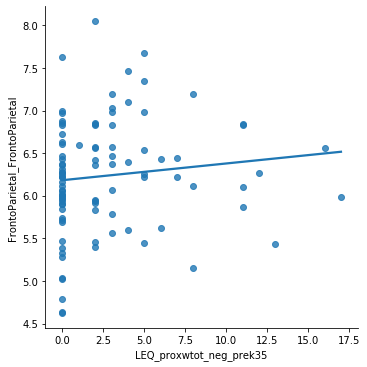

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
figsize=(3,5)
plt.figure(figsize=figsize)
sns.lmplot(x='LEQ_proxwtot_neg_prek35',y='FrontoParietal_FrontoParietal',data=full_data, ci=None)

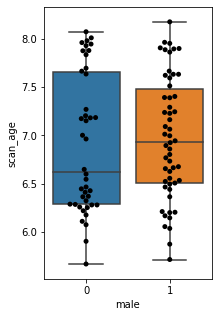

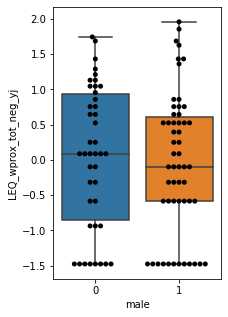

<Figure size 432x288 with 0 Axes>

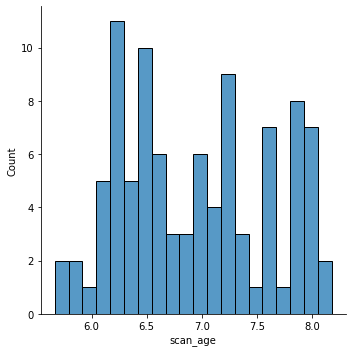

<Figure size 432x288 with 0 Axes>

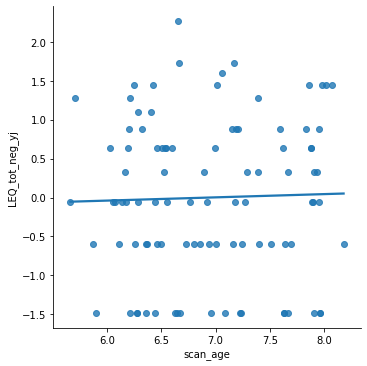

<Figure size 432x288 with 0 Axes>

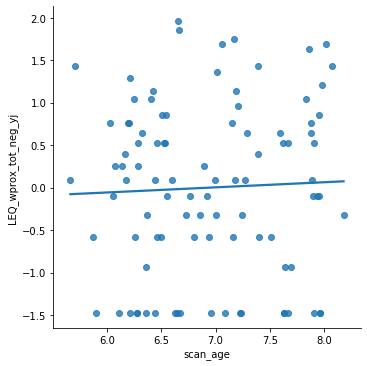

<Figure size 432x288 with 0 Axes>

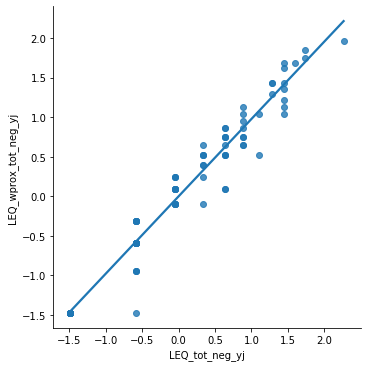

In [19]:
import seaborn as sns
figsize=(3,5)
plt.figure(figsize=figsize)
sns.boxplot(y='scan_age',x='male',data=full_data)
sns.swarmplot(y='scan_age',x='male',data=full_data, color='black')

plt.figure(figsize=figsize)
sns.boxplot(y='LEQ_wprox_tot_neg_yj',x='male',data=full_data)
sns.swarmplot(y='LEQ_wprox_tot_neg_yj',x='male',data=full_data, color='black')

plt.figure()
sns.displot(full_data['scan_age'],kind='hist',bins=20)

plt.figure()
sns.lmplot(y='LEQ_tot_neg_yj',x='scan_age',data=full_data, ci=None)

plt.figure()
sns.lmplot(y='LEQ_wprox_tot_neg_yj',x='scan_age',data=full_data, ci=None)

plt.figure()
sns.lmplot(y='LEQ_wprox_tot_neg_yj',x='LEQ_tot_neg_yj',data=full_data, ci=None)